ЗАДАЧА 
проанализировать данные о банковских клиентах, выпалтивших или невыплативших кредит и сделать прогноз на выплату кредита исходя из предложенных признаков.
План:
1. Корректируем исходные данные
2. Визуализируем зависимость вероятности невозврата долга от признаков
3. Строим скоринговые модели xgboost и RandomForestClassifier и Catboost и сравниваем их качество
4. Визуализируем скоринговую карту (SHAP)

Признаки клиентов банка:

- ```age``` - возраст (вещественный)
- ```MonthlyIncome``` - месячный доход (вещественный)
- ```DebtRatio``` - Debt-to-income Ratio (вещественный)
- ```NumberOfOpenCreditLinesAndLoans``` - число заемов и кредитных линий
- ```NumberRealEstateLoansOrLines``` - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- ```NumberOfDependents``` - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- ```defaulted``` - выплачен или не выплачен в конечном итоге кредит заемщиком

In [ ]:
pip install catboost

In [ ]:
from sklearn import ensemble , model_selection, metrics 
from sklearn.model_selection import learning_curve

import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgbm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Загрузим файл с локального диска
from google.colab import files
uploaded = files.upload()


Saving bank_to_predict.xlsx to bank_to_predict.xlsx


In [ ]:
uploaded = files.upload()

Saving credit_data.zip to credit_data (1).zip


In [ ]:
!unzip credit_data.zip

Archive:  credit_data.zip
  inflating: credit_data.csv         


In [ ]:
df = pd.read_csv("credit_data.csv")
df_to_predict = pd.read_excel("bank_to_predict.xlsx")
df.shape
df.columns

Index(['defaulted', 'age', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents', 'age_group', 'alone_and_poor'],
      dtype='object')

Доля пропусков

In [ ]:

df.isnull().sum()

defaulted                              0
age                                    0
DebtRatio                              0
MonthlyIncome                      29731
NumberOfOpenCreditLinesAndLoans        0
NumberRealEstateLoansOrLines           0
NumberOfDependents                  3924
age_group                              0
alone_and_poor                         0
dtype: int64

In [ ]:
df.isnull().mean().sort_values(ascending=False)

MonthlyIncome                      0.198207
NumberOfDependents                 0.026160
alone_and_poor                     0.000000
age_group                          0.000000
NumberRealEstateLoansOrLines       0.000000
NumberOfOpenCreditLinesAndLoans    0.000000
DebtRatio                          0.000000
age                                0.000000
defaulted                          0.000000
dtype: float64

# Удалим нулевые значения

In [ ]:
df_nonull = df.dropna(axis = 0, inplace = False)
df_nonull.isnull().mean().sort_values(ascending=False)

alone_and_poor                     0.0
age_group                          0.0
NumberOfDependents                 0.0
NumberRealEstateLoansOrLines       0.0
NumberOfOpenCreditLinesAndLoans    0.0
MonthlyIncome                      0.0
DebtRatio                          0.0
age                                0.0
defaulted                          0.0
dtype: float64

## Создадим новые группы признаков для визуализации

In [ ]:
df.describe()

,defaulted,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,age_group,alone_and_poor
count,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,146076.000000,150000.000000,150000.000000
mean,0.066840,52.295207,353.005076,6.670221e+03,8.452760,1.018240,0.757222,1.460720,0.058127
std,0.249746,14.771866,2037.818523,1.438467e+04,5.145951,1.129771,1.115086,0.626019,0.233984
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,41.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,52.000000,0.366508,5.400000e+03,8.000000,1.000000,0.000000,2.000000,0.000000
75%,0.000000,63.000000,0.868254,8.249000e+03,11.000000,2.000000,1.000000,2.000000,0.000000
max,1.000000,109.000000,329664.000000,3.008750e+06,58.000000,54.000000,20.000000,2.000000,1.000000


In [ ]:
def age_new (row):
  if row <= 45:
        return "<45" 
  elif 45 < row <= 60:
        return "<45<60"
  else:
        return ">60"
df_nonull["age_new"] = df_nonull["age"].apply(age_new)

def DebtRatio_new (row):
    if row <= 0.3:
        return "<0.3" 
    elif 0.3 < row <= 0.5:
        return "<0.3<0.5"
    else:
        return ">0.5"
df_nonull['DebtRatio_new'] = df_nonull['DebtRatio'].apply( DebtRatio_new)

def MonthlyIncome_new (row):
    if row <= 4500:
        return "<4500" 
    elif 4500 < row <= 10000:
        return "<4500<10000"
    else:
        return ">10000"
df_nonull['MonthlyIncome_new'] = df_nonull['MonthlyIncome'].apply( MonthlyIncome_new)

  


# Рассмотрим взаимосвязь признаков и невозвратом кредита

## Визуализация данных 
Рассмотрим:
1. Тепловую карту
2. Долю невернувших кредит в зависимости от признаков
3. Распределение признаков у невернувших кредит

['defaulted'] = 1 - невернувший креди

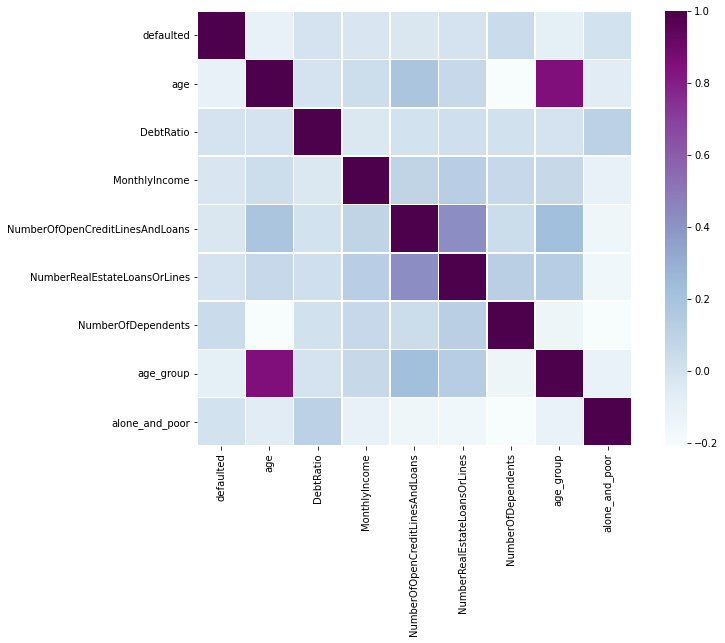

In [ ]:
import seaborn as sns
corr_all = df_nonull.corr()

fig, ax0 = plt.subplots(figsize = (12, 8))
sns.heatmap(corr_all,
            square = True, linewidths = .5, ax = ax0,cmap = "BuPu")    
plt.show()

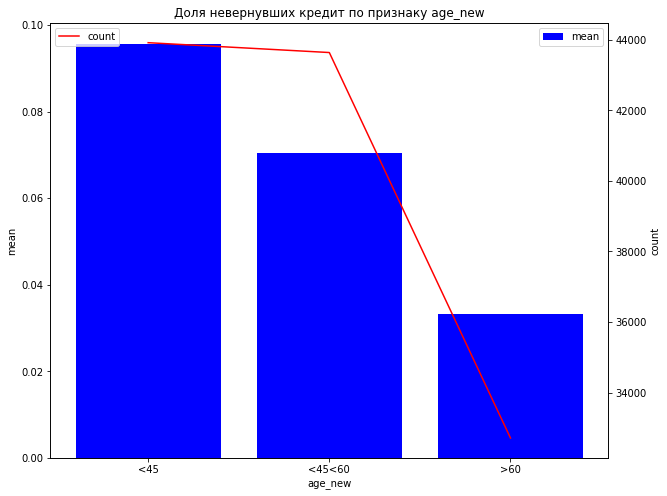

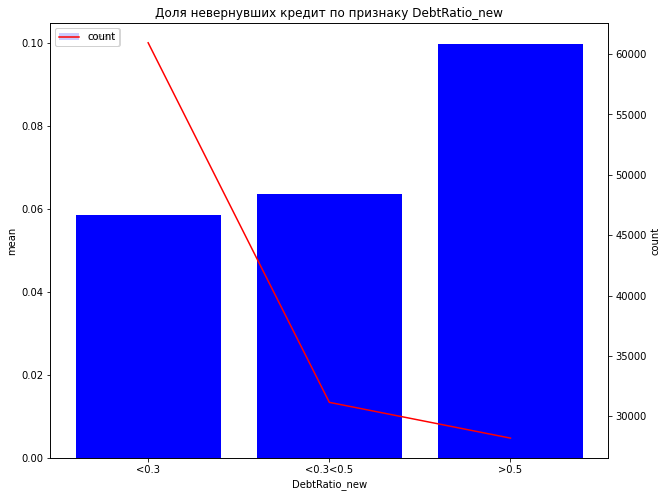

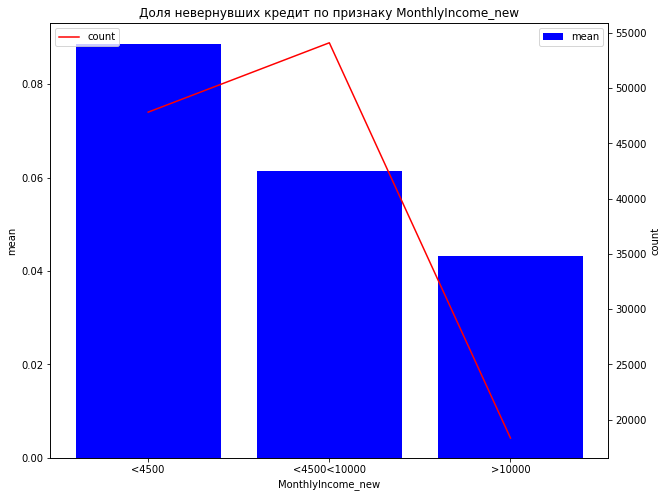

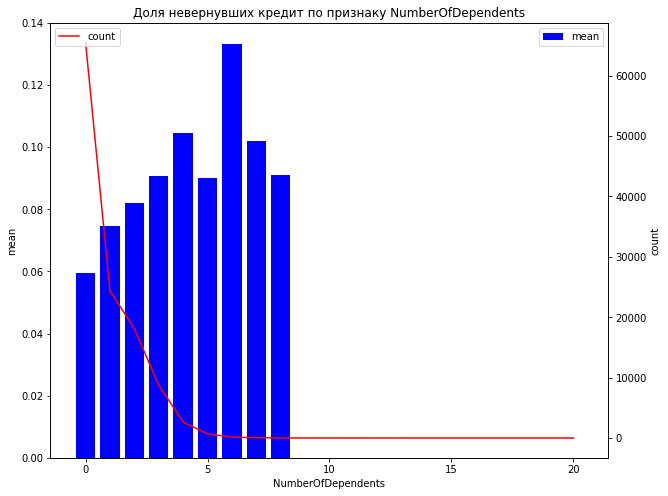

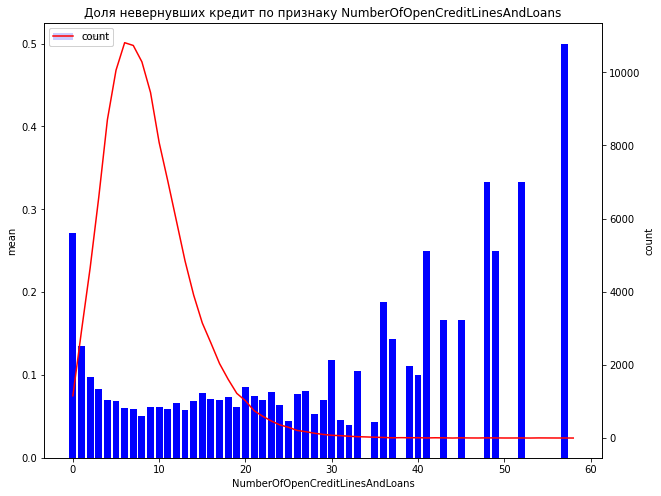

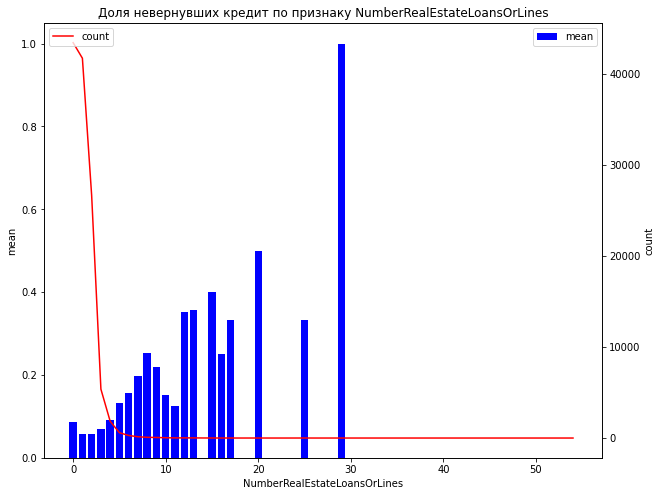

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
for i in ['age_new', 'DebtRatio_new','MonthlyIncome_new','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']:
    
    df_grouped = df_nonull.groupby([i])["defaulted"].agg(['count', 'mean'])
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    ax1.set_title("Доля невернувших кредит по признаку {}".format(i))
    ax1.set_xlabel(i)
    ax1.set_ylabel('mean')
    ax1.bar(df_grouped.index.values,df_grouped['mean'].values, label ='mean', color ="b" )
    ax2 = ax1.twinx()  
    ax2.set_ylabel('count')
    ax2.plot(df_grouped.index.values ,df_grouped['count'].values, label ='count', color ="r")
    ax1.legend()  
    ax2.legend(loc='upper left')  
    plt.show()
    
  

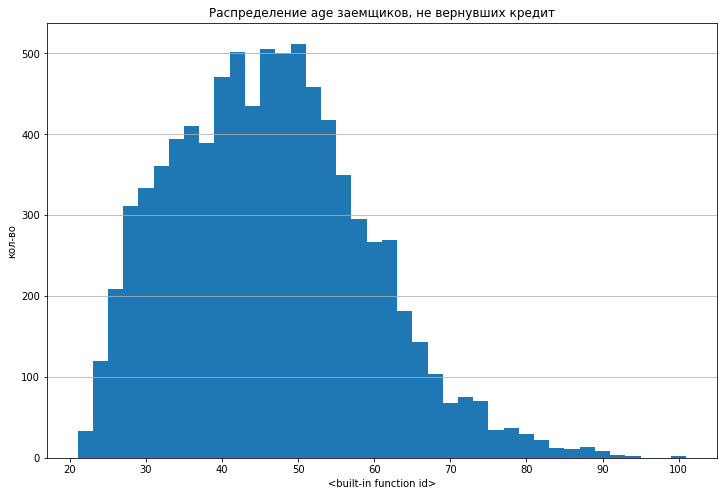

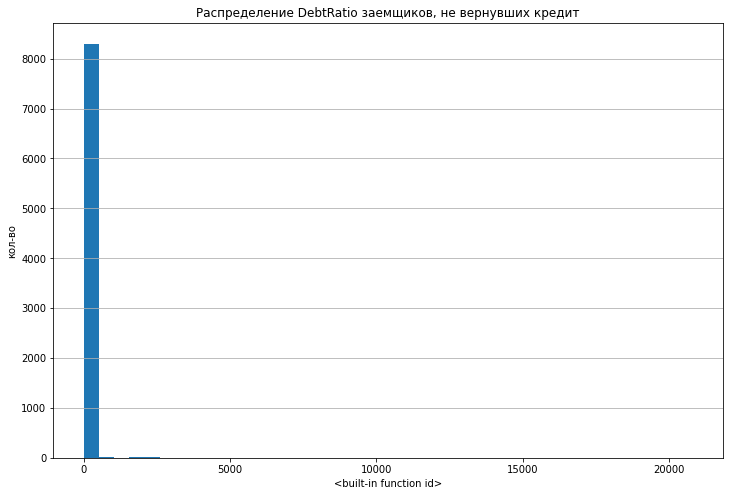

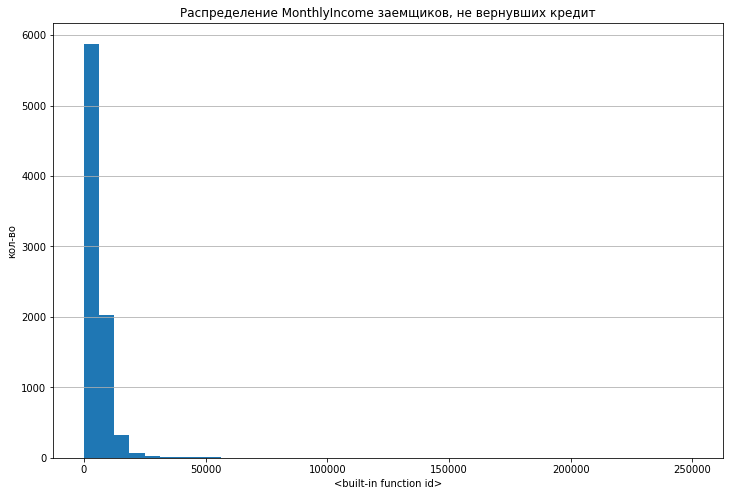

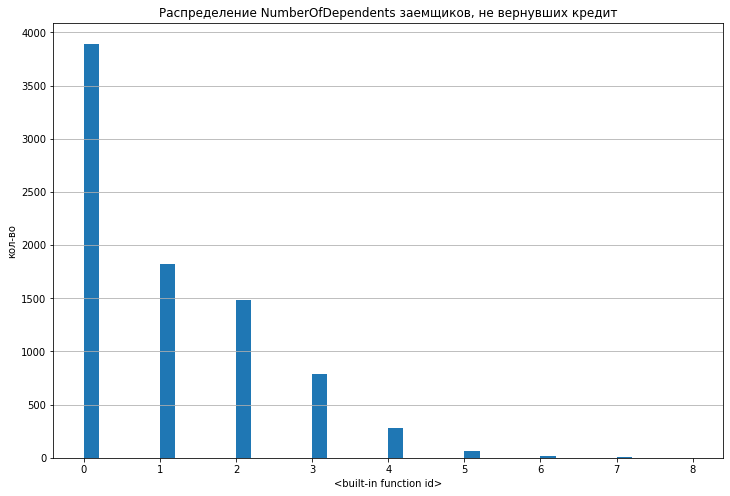

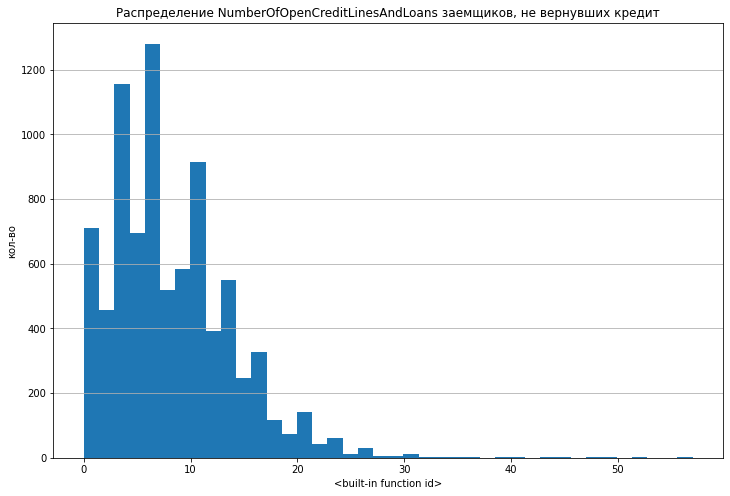

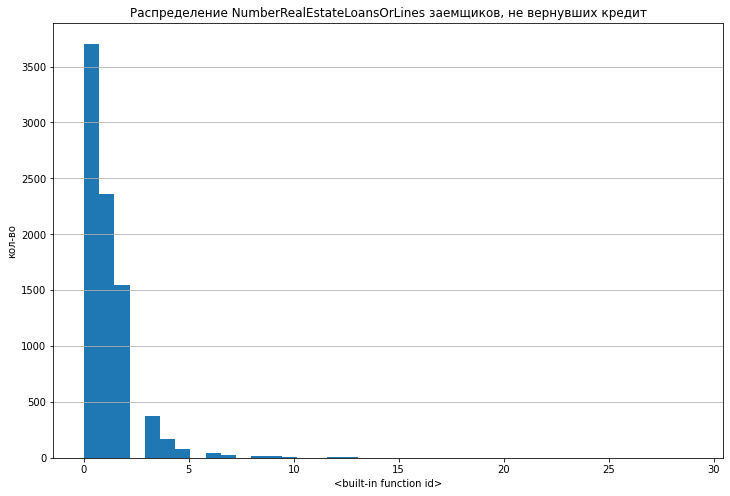

In [ ]:

for i in ['age', 'DebtRatio','MonthlyIncome','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']:
    plt.figure(figsize=(12,8))
    (df_nonull[df_nonull["defaulted"] == 1][i]).plot.hist(bins=40)
    plt.title("Распределение {} заемщиков, не вернувших кредит".format (i))
    plt.xlabel(id)
    plt.ylabel("кол-во")
    plt.grid(axis = "y")
    plt.show()

Предположительно есть корреляция между возвратом кредита и различными признаками:

В-целом вероятность невозврата повышается:
чем меньше возраст, уровень дохода, чем выше debtratio,количество иждивенцев и других кредитных линий

## Построим скоринговую модель (классификация)

In [ ]:
# Данные для анализа
df_X = df_nonull[[ 'age', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents']]
df_target = df_nonull["defaulted"].values


In [ ]:
# Разделим на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(df_X, df_target, train_size = 0.7, random_state = 1234)

In [ ]:
from tqdm import tqdm_notebook
ensemble.RandomForestClassifier

sklearn.ensemble._forest.RandomForestClassifier

## Используем две модели и сравним их метрики качества

In [ ]:
estimatorRFC = ensemble.RandomForestClassifier(n_estimators = 50, 
                                                min_samples_split=5, 
                                                random_state=1)
estimatorRFC.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
estimatorXGB = xgb.XGBClassifier(learning_rate=0.15, 
                                  max_depth=8, 
                                  n_estimators=50)
estimatorXGB.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
estimatorCB = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2)
estimatorCB.fit(X_train, y_train)


0:	learn: 0.2827588	total: 56.7ms	remaining: 5.61s
1:	learn: 0.2491218	total: 65ms	remaining: 3.19s
2:	learn: 0.2429143	total: 73.1ms	remaining: 2.36s
3:	learn: 0.2405755	total: 81.2ms	remaining: 1.95s
4:	learn: 0.2389902	total: 89ms	remaining: 1.69s
5:	learn: 0.2378795	total: 96.8ms	remaining: 1.52s
6:	learn: 0.2370075	total: 105ms	remaining: 1.39s
7:	learn: 0.2367163	total: 112ms	remaining: 1.29s
8:	learn: 0.2358592	total: 120ms	remaining: 1.22s
9:	learn: 0.2355800	total: 128ms	remaining: 1.15s
10:	learn: 0.2352805	total: 137ms	remaining: 1.11s
11:	learn: 0.2349661	total: 146ms	remaining: 1.07s
12:	learn: 0.2347655	total: 154ms	remaining: 1.03s
13:	learn: 0.2344168	total: 162ms	remaining: 995ms
14:	learn: 0.2342838	total: 170ms	remaining: 962ms
15:	learn: 0.2340707	total: 178ms	remaining: 933ms
16:	learn: 0.2339324	total: 185ms	remaining: 905ms
17:	learn: 0.2337634	total: 193ms	remaining: 880ms
18:	learn: 0.2337154	total: 201ms	remaining: 856ms
19:	learn: 0.2335305	total: 209ms	remai

Найдем ошибки для каждой модели

In [ ]:

estimatorRFC.predict(X_test)
estimatorXGB.predict(X_test)
estimatorCB.predict(X_test)
print("accuracy RFC", sum(np.array(y_test) == estimatorRFC.predict(X_test))/len(np.array(y_test)))
print("accuracy XGB", sum(np.array(y_test) == estimatorXGB.predict(X_test))/len(np.array(y_test)))
print("accuracy CB", sum(np.array(y_test) == estimatorCB.predict(X_test))/len(np.array(y_test)))

accuracy RFC 0.9293256838779413
accuracy XGB 0.9301294310024667
accuracy CB 0.9302680080929021


В-целом у всех моделей хороший и близкий результат

In [ ]:
# Оценим вероятность вовзрата кредита у следующих клиентов (из файла df_to_predict)
estimatorXGB.predict_proba(df_to_predict)


array([[0.87874293, 0.12125707],
       [0.94651157, 0.05348844],
       [0.9833245 , 0.01667544],
       [0.86050147, 0.13949853],
       [0.8415303 , 0.15846968]], dtype=float32)

### Карта признаков Shap

In [ ]:
!pip install shap
import shap
shap.initjs()

     |████████████████████████████████| 327kB 8.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456460 sha256=6b8d1f7d04748ea8ebf912e4950d27461f6464a95019b429a26c1098aa75bcd5
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


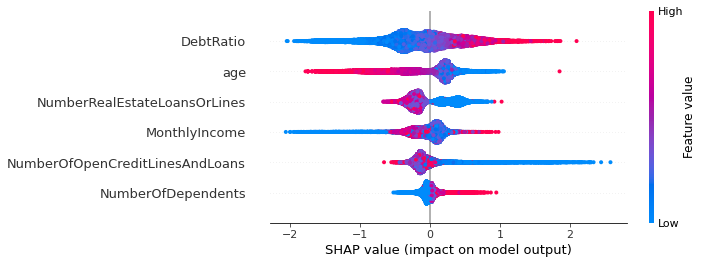

In [ ]:
explainer = shap.TreeExplainer(estimatorXGB, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


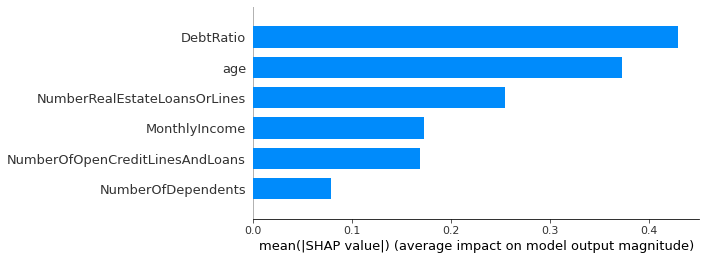

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

По карте признаков:
 
Наиболее влияемые факторы это debtration и возраст.
Положительно влияют debtration и numberofindependents